In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.models.video as video_models
import matplotlib.pyplot as plt

In [2]:
data_root="data_s_50_2"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class VideoPairDataset(Dataset):
    def __init__(self, root_dir, num_frames=16, frame_height=64, frame_width=64):
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.frame_height = frame_height
        self.frame_width = frame_width

        self.class_to_videos = {}
        for cls in os.listdir(root_dir):
            class_folder = os.path.join(root_dir, cls)
            if os.path.isdir(class_folder):
                self.class_to_videos[cls] = [
                    os.path.join(class_folder, video_file)
                    for video_file in os.listdir(class_folder)
                    if video_file.endswith(('.avi'))
                ]
        self.classes = list(self.class_to_videos.keys())

    def __len__(self):
        return sum(len(videos) for videos in self.class_to_videos.values())

    def __getitem__(self, idx):
        class1 = random.choice(self.classes)
        video1_path = random.choice(self.class_to_videos[class1])

        same_class = random.choice([True, False])
        if same_class:
            class2 = class1
        else:
            class2 = random.choice([cls for cls in self.classes if cls != class1])

        video2_path = random.choice(self.class_to_videos[class2])

        video1 = self._read_video(video1_path)
        video2 = self._read_video(video2_path)

        # Label: 0 for same class, 1 for different classes
        label = torch.tensor([0.0]) if same_class else torch.tensor([1.0])

        return video1, video2, label

    def _read_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)

        frames = []
        for i in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (self.frame_width, self.frame_height))
            frames.append(frame)

        cap.release()

        frames = np.stack(frames, axis=0)
        frames = frames.transpose((3, 0,1, 2))
        return torch.tensor(frames, dtype=torch.float32) / 255.0

In [ ]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetFeatureExtractor, self).__init__()
        r3d_18 = video_models.r3d_18(pretrained=pretrained)
        self.features = nn.Sequential(*list(r3d_18.children())[:-2])
        self.pool = nn.AdaptiveAvgPool3d(1)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return x.flatten(1)


class SceneChangeDetector(nn.Module):
    def __init__(self, embedding_dim=512):
        super(SceneChangeDetector, self).__init__()
        self.feature_extractor = ResNetFeatureExtractor(pretrained=True)
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, video1, video2):
        embed1 = self.feature_extractor(video1)
        embed2 = self.feature_extractor(video2)
        combined = torch.cat([embed1, embed2], dim=1)
        x = self.relu(self.fc1(combined))
        x = self.fc2(x)
        return x

In [ ]:
training_root_dir = f"{data_root}/training"
training_dataset = VideoPairDataset(root_dir=training_root_dir)
training_dataloader = DataLoader(training_dataset, batch_size=8, shuffle=True)

validation_root_dir = f"{data_root}/validation"
validation_dataset = VideoPairDataset(root_dir=validation_root_dir) 
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

testing_root_dir = f"{data_root}/testing"
testing_dataset = VideoPairDataset(root_dir=testing_root_dir)
testing_dataloader = DataLoader(testing_dataset, batch_size=8, shuffle=True)

In [ ]:
model = SceneChangeDetector(embedding_dim=512).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
def validate():
    with torch.no_grad():
        total_tests=0
        total_matches=0
        i=0
        for video1, video2, labels in validation_dataloader:
            i+=1
            total_tests+=1*video1.shape[0]
            outputs = model(video1.to(device), video2.to(device))
            outputs= (outputs > 0.5).float()
            labels=labels.to(device)
            matches=(outputs ==labels).sum()
            total_matches+=matches.item()
        accuracy=total_matches/total_tests
        print(f"accuracy {accuracy},total_test {total_tests}")
        return accuracy

In [ ]:
loss_list=[]
accuracy_list=[]
epochs=400
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for video1, video2, labels in training_dataloader:
        #print(video1.shape)
        #print(labels)
        optimizer.zero_grad()
        outputs = model(video1.to(device), video2.to(device))
        #print(outputs)
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_list.append(total_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")
    if epoch %10 ==0:
        acc=validate()
        accuracy_list.append(acc)

In [35]:
torch.save(model.state_dict(), "best_weights_slippery_400_epochs")

In [25]:
def test():
    with torch.no_grad():
        total_tests=0
        total_matches=0
        for video1, video2, labels in testing_dataloader:
            total_tests+=1*video1.shape[0]
            outputs = model(video1.to(device), video2.to(device))
            outputs= (outputs > 0.5).float()
            labels=labels.to(device)
            matches=(outputs ==labels).sum()
            total_matches+=matches.item()
        accuracy=total_matches/total_tests
        print(f"testing accuracy {accuracy},total_test {total_tests}")

In [39]:
test()

testing accuracy 0.92,total_test 100


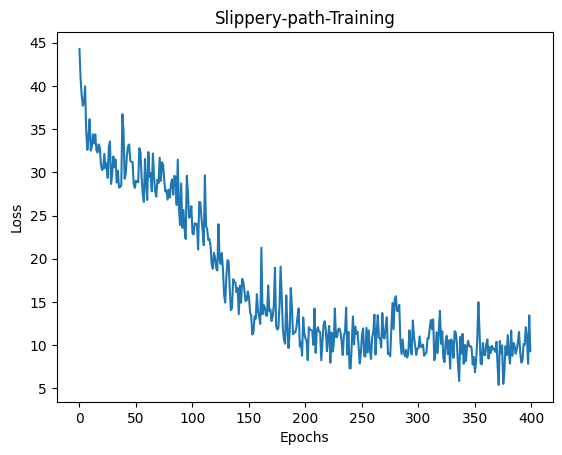

In [37]:
plt.plot(range(len(loss_list)),loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Slippery-path-Training')
plt.savefig('training-loss.png') 

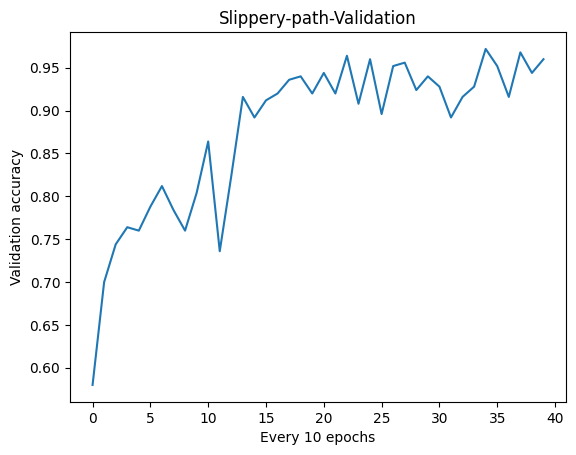

In [38]:
plt.plot(range(len(accuracy_list)),accuracy_list)
plt.xlabel('Every 10 epochs')
plt.ylabel('Validation accuracy')
plt.title('Slippery-path-Validation')
plt.savefig('validation-accuracy.png') 